In [1]:
from generate_data import Data
from evaluate import *
from models import *

import pandas as pd
import numpy as np

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cpu


In [3]:
%autosave 120

Autosaving every 120 seconds


# Get the synthetic dataset

In [4]:
%%time
data = Data(layer_size=16, interop_distances=[0,1,2])

C:\Users\Luna Santos\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\base.py:486: UserWarning: X has feature names, but OneHotEncoder was fitted without feature names
  warnings.warn(


CPU times: total: 3.47 s
Wall time: 4.06 s


In [5]:
%%time
train, val, test = data.get_splits(['omit_distances', 'random_subsample'], [[0, 2], [0.1, 0.9]])

train_unshuffled = train.copy()
np.random.shuffle(train)

x_train, y_train = data.get_x_y(train)
x_val, y_val = data.get_x_y(val)
x_test, y_test = data.get_x_y(test)

train_original = data.reverse_encoding(data.get_x_y(train_unshuffled)[0])
val_original = data.reverse_encoding(x_val)
test_original = data.reverse_encoding(x_test)

Number of samples: 541 train | 1533 val | 6132 test
CPU times: total: 4min 9s
Wall time: 4min 23s


#### Peek at unshuffled train data

In [6]:
train_original[:20]

[['___,,_..,___.,,,', ',._.,.u_w.,__.__', '.,,_d,r,.,.,,,,,', True],
 [',_._,___,_,_,_,,', '.,._.._,,,.w,u,,', ',,,,.,,c.r.,___,', False],
 ['_,.,._,,._,,..,_', '.,.__...___..,,.', '._,_r,_,.,,,.___', True],
 ['.._,_.,._,_,.__.', '__,,w,..,,_.,.,.', '_.___,,._,__,...', False],
 ['_,_,_,.,...,,,_,', '.___,.,.....__.,', 'r.._,._,._,,..,,', True],
 ['__...,_.._,,,.,.', ',._,,,,,,,,,_w._', '..._r,__,_,._,..', True],
 ['_,_,,,_,,._,,.,.', '.__,,__._.,_.,_.', ',__._,.,.__,_.__', False],
 ['.,,_..__,,_.._._', '_,_,_...w___._,,', ',,._,____,,__._.', False],
 [',_.,..___,,_,.._', '..,____.u.w_,,,,', '_.,_._r_,._._,_.', True],
 ['_,__.,,_...._,,_', ',..,_,_,_w,._._,', '..c_r_.,,,....,.', False],
 ['_,._..,____,.,.,', ',_,_.._w,,_.__,.', ',.,,,._,..,___,.', False],
 ['_.._.___,._._._,', '._...,_,__,._,_.', '__..,_,.r___.,.,', True],
 ['..,,_,_...._.,__', ',_w.,..._.____._', 'r_,_,.,,,__...,_', True],
 [',__,.__,_,..__,.', '._..,_..u.w,.,_.', ',,,,,_._,_.,,_,.', False],
 ['_,._.._,.,..,_..', ',_,,

In [7]:
pos_train_ratio = get_stats_and_ratio(train_original)

Number of samples by case:
F3 dr:    F2-wu 24 | F2-uw 13 | F2-w 22 | F2-noop 24 | 
F3 cr:    F2-wu 15 | F2-uw 18 | F2-w 19 | F2-noop 31 | 
F3 r:    F2-wu 22 | F2-uw 19 | F2-w 64 | F2-noop 75 | 
F3 noop:    F2-wu 22 | F2-uw 22 | F2-w 78 | F2-noop 73 | 

Positive samples count: 239
Total samples count: 541
Positive class ratio: 0.4417744916820702


#### Peek at test data

In [8]:
test_original[:15]

[['_...__._,.____.,', '__,_.._,.uw,__,_', '___.,__,__,__dr.', True],
 ['..,._.,_,._,.,,.', ',,,.uw,.,,,.___,', ',__dr_,..,,__,,,', True],
 [',,_,_,_,__.,,,,.', '___w._u_,.,._.,,', '._.,__,,,._,c_.r', False],
 ['._.,...,_...,,,.', '_,,.,,wu,,_,,,,,', '_,.,_,___,,____.', False],
 ['._,.,,,_,___.,__', '.,,,_,,.,.,..,,.', '_,_.___.._,r._,_', True],
 [',._._,.._,_,_.,.', '..uw._.__,...,.,', '.,,._,,._,_.__,_', False],
 ['_..,....__.__,.,', '.wu,..,,,._.,..,', '._.____,.,_.__,_', False],
 ['_....,.,__,,__,_', ',.,__....,_,.,.,', '_,,.,_..__...,,,', False],
 ['_,._._..,..__.,,', ',,,..,,,,_,.._w.', '.,..,.,.,.._,...', False],
 [',,___,_,.._,,,,,', ',__,._._,,,,w,__', '.._.,_.,,._dr__.', True],
 ['_._,_,_...._._._', ',_.__.wu_.,,_,_,', '_..,,r._,_.._.,.', True],
 ['_,,_,,.,._.,..__', '_._.._,,_.__wu,,', '___.,_,_._,,.,,,', False],
 [',,.,_.,,,,_.,,__', '_,.,,.,_,w,,u.._', ',_,._..._..____.', False],
 ['__,__,_,..__.._,', '.__.,_,____,_,,.', ',.,.___.._...,dr', True],
 ['_._,,...___,,_,_', ',,,

In [9]:
pos_test_ratio = get_stats_and_ratio(test_original)

Number of samples by case:
F3 dr:    F2-wu 315 | F2-uw 309 | F2-w 326 | F2-noop 365 | 
F3 cr:    F2-wu 333 | F2-uw 306 | F2-w 341 | F2-noop 369 | 
F3 r:    F2-wu 347 | F2-uw 335 | F2-w 483 | F2-noop 524 | 
F3 noop:    F2-wu 351 | F2-uw 369 | F2-w 511 | F2-noop 548 | 

Positive samples count: 2689
Total samples count: 6132
Positive class ratio: 0.43851924331376385


#### Peek at val data

In [10]:
val_original[:15]

[[',_._,___.,.,,,.,', ',.,_.__.__,,,...', '.,,..___.__,,.cr', False],
 ['_______,.,_.,._,', '.,_._,,__,.,.wu,', ',_.__._,,,.,__,,', False],
 ['__..,.._.,__,.__', '.___,_.w_._,_...', ',_,_,.,_..,,____', False],
 ['.._.,.,,._.._..,', ',..,_w..,.,,.,_.', ',_..,,._r__,,_,_', True],
 ['_____.___._,..,,', '.,___,._,.,w_,._', ',_.,r..,_,._,_,,', True],
 [',.,,_.,,,__.,__.', ',.,,,,.,u,,w.._,', 'd,_r_,_....,,._,', True],
 ['._.,,_,,.,._,_,.', '.__.__._uw..,,,,', '_.__,,_.dr_,,.._', True],
 ['.,__,.,.....,.,.', '..__uw_.___,___,', '__,..._,.r._,.,_', True],
 ['_._____.._.._,,,', '.,__wu._,,,.____', '_,___cr,_.,_.__.', False],
 ['...._..,_.,.._,,', '._w..u_.__..,.,.', '__._,_.,._,,d.,r', False],
 ['._,.._,,.,,__.,.', '_..._,...,_,,_,,', '_,_._,r..__,._,,', True],
 [',_,__.,,__,,..__', ',,__,,,._._,wu_.', '.cr..,,,,._,.._,', False],
 [',,.,.,._,__.,,,_', '_...,..._.w__._.', ',._..,.d..r.,._.', True],
 ['._._,_,_,,_,_,_,', '.__..,.,__.u__w_', ',_,,,_.,,..,r,.,', True],
 ['_..__.,..,,...,,', ',,,_w

In [11]:
pos_val_ratio = get_stats_and_ratio(val_original)

Number of samples by case:
F3 dr:    F2-wu 79 | F2-uw 85 | F2-w 96 | F2-noop 85 | 
F3 cr:    F2-wu 61 | F2-uw 88 | F2-w 81 | F2-noop 81 | 
F3 r:    F2-wu 75 | F2-uw 87 | F2-w 130 | F2-noop 123 | 
F3 noop:    F2-wu 99 | F2-uw 81 | F2-w 133 | F2-noop 149 | 

Positive samples count: 681
Total samples count: 1533
Positive class ratio: 0.44422700587084146


#### Send label arrays to device

In [12]:
y_train = torch.from_numpy(y_train.astype(float)).float().to(device)
y_val = torch.from_numpy(y_val.astype(float)).float().to(device)
y_test = torch.from_numpy(y_test.astype(float)).float().to(device)

#### Get data in normal format (same as CNN format)

In [13]:
x_train_normal = data.to_conv_format(x_train)
x_val_normal = data.to_conv_format(x_val)
x_test_normal = data.to_conv_format(x_test)
for i in range(len(x_train_normal)):
    x_train_normal[i] = x_train_normal[i].to(device)
    x_val_normal[i] = x_val_normal[i].to(device)
    x_test_normal[i] = x_test_normal[i].to(device)

In [14]:
x_train_normal[0].shape

torch.Size([541, 128])

#### Get data in convolutional format, send to device

In [15]:
x_train_cnn = data.to_conv_format(x_train, padding_left_size=2, padding_right_size=2)
x_val_cnn = data.to_conv_format(x_val, padding_left_size=2, padding_right_size=2)
x_test_cnn = data.to_conv_format(x_test, padding_left_size=2, padding_right_size=2)
for i in range(len(x_train_cnn)):
    x_train_cnn[i] = x_train_cnn[i].to(device)
    x_val_cnn[i] = x_val_cnn[i].to(device)
    x_test_cnn[i] = x_test_cnn[i].to(device)

In [16]:
x_train_cnn[0].shape

torch.Size([541, 160])

#### Get data in LSTM format, send to device

In [17]:
x_train_lstm = data.to_lstm_format(x_train)
x_val_lstm = data.to_lstm_format(x_val)
x_test_lstm = data.to_lstm_format(x_test)
for i in range(len(x_train_lstm)):
    x_train_lstm[i] = x_train_lstm[i].to(device)
    x_val_lstm[i] = x_val_lstm[i].to(device)
    x_test_lstm[i] = x_test_lstm[i].to(device)

In [18]:
x_train_lstm[0].shape

torch.Size([541, 16, 8])

### Define training parameters

In [19]:
num_experiments = 20
epochs = 200
early_stopping_limit = 100
experiment_name = "interop_2"


### Define training procedure for each model

In [20]:
def train_models(constructor, x_train, x_val, x_test, weight_decay, *argv):
    accuracies = [] #lista con la precisión de cada modelo en el cjto de prueba
    precisions = []
    recalls = []
    f1_scores = []
    wrong_preds = []#lista con las predicciones incorrectas del modelo en el cjto de prueba
    best_accuracy = 0
    
    #listas de listas de cada modelo durante el entrenamiento y prueba
    train_losses = []
    val_losses = []
    train_accs = []
    val_accs = []

    for i in range(num_experiments):
        model = constructor(*argv)
        model.to(device)

        criterion = nn.BCEWithLogitsLoss(pos_weight=torch.Tensor([(1-pos_train_ratio)/pos_train_ratio]).to(device))
        optimizer = optim.Adam(model.parameters(), weight_decay=weight_decay)

        train_losses.append([])
        val_losses.append([])
        train_accs.append([])
        val_accs.append([])
        
        best_acc = 0

        early_stopping_cnt = 0

        for epoch in range(1, epochs + 1):
            train_loss, train_acc = train_epoch(model, x_train, y_train, criterion, optimizer, epoch, 10, verbose=False)
            val_loss, val_acc = eval_epoch(model, x_val, y_val, criterion, 'Validation', verbose=False)

            
            train_losses[-1].append(train_loss)
            val_losses[-1].append(val_loss)
            train_accs[-1].append(train_acc)
            val_accs[-1].append(val_acc)
            
            model_name = constructor.__name__[:constructor.__name__.find('_')]
            if val_acc > best_acc:
                best_acc = val_acc
                torch.save(model.state_dict(), f'./temp/{model_name}_model_TEMP_' + experiment_name)    
                early_stopping_cnt = 0
            else:
                early_stopping_cnt += 1

            if early_stopping_cnt >= early_stopping_limit:
                break

        model.load_state_dict(torch.load(f'./temp/{model_name}_model_TEMP_' + experiment_name))

        accuracies.append(get_accuracy_by_cases(model, x_test, y_test, test_original)) #Se evalúa el modelo en el conjunto de prueba 
        precisions.append(get_precision(model, x_test, y_test, test_original))
        recalls.append(get_recall(model, x_test, y_test, test_original))
        f1_scores.append(get_f1(precisions[-1], recalls[-1]))        
        
        wrong_preds.append(get_wrong_predictions(model, x_test, y_test, test_original))

        if accuracies[-1]['Overall'] > best_accuracy:
            torch.save(model.state_dict(), f'./bestmodels/best_{model_name}_model_' + experiment_name)    
            best_accuracy = accuracies[-1]['Overall']

        print(i + 1, "/", num_experiments, "models trained | Current model best validation accuracy:", best_accuracy)

    return accuracies, precisions, recalls, f1_scores,  wrong_preds, [train_losses, val_losses, train_accs, val_accs]

# Train models

In [21]:
%%time
cnn_accuracies, cnn_precisions, cnn_recall, cnn_f1_scores, cnn_wrong_preds, cnn_epoch_stats = train_models(CNN_Model, x_train_cnn, x_val_cnn, x_test_cnn, 0.005, data, 32, 64, 4, -1, 'keras')


1 / 20 models trained | Current model best validation accuracy: 0.9486301369863014
2 / 20 models trained | Current model best validation accuracy: 0.9486301369863014
3 / 20 models trained | Current model best validation accuracy: 0.9486301369863014
4 / 20 models trained | Current model best validation accuracy: 0.9486301369863014
5 / 20 models trained | Current model best validation accuracy: 0.9489562948467059
6 / 20 models trained | Current model best validation accuracy: 0.9489562948467059
7 / 20 models trained | Current model best validation accuracy: 0.9489562948467059
8 / 20 models trained | Current model best validation accuracy: 0.9489562948467059
9 / 20 models trained | Current model best validation accuracy: 0.9489562948467059
10 / 20 models trained | Current model best validation accuracy: 0.9489562948467059
11 / 20 models trained | Current model best validation accuracy: 0.9489562948467059
12 / 20 models trained | Current model best validation accuracy: 0.9489562948467059
1

In [22]:
%%time
lstm_accuracies, lstm_precisions, lstm_recall, lstm_f1_scores, lstm_wrong_preds, lstm_epoch_stats = train_models(LSTM_Model, x_train_lstm, x_val_lstm, x_test_lstm, 0.0001, data, 16, 32, 8, 'keras')

1 / 20 models trained | Current model best validation accuracy: 0.9990215264187867
2 / 20 models trained | Current model best validation accuracy: 0.9990215264187867
3 / 20 models trained | Current model best validation accuracy: 0.9990215264187867
4 / 20 models trained | Current model best validation accuracy: 0.9990215264187867
5 / 20 models trained | Current model best validation accuracy: 0.9990215264187867
6 / 20 models trained | Current model best validation accuracy: 0.9990215264187867
7 / 20 models trained | Current model best validation accuracy: 0.9990215264187867
8 / 20 models trained | Current model best validation accuracy: 0.9990215264187867
9 / 20 models trained | Current model best validation accuracy: 1.0
10 / 20 models trained | Current model best validation accuracy: 1.0
11 / 20 models trained | Current model best validation accuracy: 1.0
12 / 20 models trained | Current model best validation accuracy: 1.0
13 / 20 models trained | Current model best validation accura

In [23]:
%%time
deepset_accuracies, deepset_precisions, deepset_recall, deepset_f1_scores,deepset_wrong_preds, deepset_epoch_stats = train_models(DEEPSET_Model, x_train_normal, x_val_normal, x_test_normal, 0.0001, data, 128, 32, 8, 'keras')

1 / 20 models trained | Current model best validation accuracy: 0.87573385518591
2 / 20 models trained | Current model best validation accuracy: 0.87573385518591
3 / 20 models trained | Current model best validation accuracy: 0.87573385518591
4 / 20 models trained | Current model best validation accuracy: 0.87573385518591
5 / 20 models trained | Current model best validation accuracy: 0.8819308545335942
6 / 20 models trained | Current model best validation accuracy: 0.8819308545335942
7 / 20 models trained | Current model best validation accuracy: 0.8878016960208741
8 / 20 models trained | Current model best validation accuracy: 0.8878016960208741
9 / 20 models trained | Current model best validation accuracy: 0.8878016960208741
10 / 20 models trained | Current model best validation accuracy: 0.8878016960208741
11 / 20 models trained | Current model best validation accuracy: 0.8878016960208741
12 / 20 models trained | Current model best validation accuracy: 0.8878016960208741
13 / 20 m

In [24]:
deepsetv2_accuracies, deepsetv2_precisions, deepsetv2_recall, deepsetv2_f1_scores, deepsetv2_wrong_preds, deepsetv2_epoch_stats = train_models(DEEPSETV2_Model, x_train_normal, x_val_normal, x_test_normal, 0.0001, data, 32, 8, 'keras')

1 / 20 models trained | Current model best validation accuracy: 0.43851924331376385
2 / 20 models trained | Current model best validation accuracy: 0.43851924331376385
3 / 20 models trained | Current model best validation accuracy: 0.43851924331376385
4 / 20 models trained | Current model best validation accuracy: 0.43851924331376385
5 / 20 models trained | Current model best validation accuracy: 0.43851924331376385
6 / 20 models trained | Current model best validation accuracy: 0.43851924331376385
7 / 20 models trained | Current model best validation accuracy: 0.43851924331376385
8 / 20 models trained | Current model best validation accuracy: 0.43851924331376385
9 / 20 models trained | Current model best validation accuracy: 0.43851924331376385
10 / 20 models trained | Current model best validation accuracy: 0.43851924331376385
11 / 20 models trained | Current model best validation accuracy: 0.43851924331376385
12 / 20 models trained | Current model best validation accuracy: 0.4385192

In [25]:
%%time
feedforward_accuracies, feedforward_precisions, feedforward_recall, feedforward_f1_scores, feedforward_wrong_preds, feedforward_epoch_stats = train_models(FEEDFORWARD_Model, x_train_normal, x_val_normal, x_test_normal, 0.0001, data, 128, 32, 8, 'keras')

1 / 20 models trained | Current model best validation accuracy: 0.8569797782126549
2 / 20 models trained | Current model best validation accuracy: 0.8745923026744945
3 / 20 models trained | Current model best validation accuracy: 0.8951402478799739
4 / 20 models trained | Current model best validation accuracy: 0.8951402478799739
5 / 20 models trained | Current model best validation accuracy: 0.8951402478799739
6 / 20 models trained | Current model best validation accuracy: 0.8951402478799739
7 / 20 models trained | Current model best validation accuracy: 0.8951402478799739
8 / 20 models trained | Current model best validation accuracy: 0.8951402478799739
9 / 20 models trained | Current model best validation accuracy: 0.8951402478799739
10 / 20 models trained | Current model best validation accuracy: 0.8951402478799739
11 / 20 models trained | Current model best validation accuracy: 0.8951402478799739
12 / 20 models trained | Current model best validation accuracy: 0.8951402478799739
1

# Evaluation

In [26]:
all_accuracies = [cnn_accuracies, lstm_accuracies, deepset_accuracies, deepsetv2_accuracies, feedforward_accuracies]
all_precisions = [cnn_precisions, lstm_precisions, deepset_precisions, deepsetv2_precisions, feedforward_precisions]
all_recalls = [cnn_recall, lstm_recall, deepset_recall, deepsetv2_recall, feedforward_recall]
all_f1_scores = [cnn_f1_scores, lstm_f1_scores, deepset_f1_scores, deepsetv2_f1_scores, feedforward_f1_scores]

model_names = ['CNN', 'LSTM', 'DeepSet(like in paper)', 'DeepSet(sum at start)', 'Feedforward']

In [28]:
get_summary_df(model_names, all_accuracies, all_precisions, all_recalls, all_f1_scores)

                   Modelo  Accuracy  Precision    Recall  F1-score
0                     CNN  0.948956   0.896529  0.998884  0.944943
1                    LSTM  1.000000   1.000000  1.000000  1.000000
2  DeepSet(like in paper)  0.894651   0.863394  0.902566  0.882545
3   DeepSet(sum at start)  0.438519   0.438519  1.000000  0.609681
4             Feedforward  0.895140   0.853246  0.918929  0.884870


## Accuracies per CNN model

In [ ]:
get_stats_per_model(cnn_accuracies, ['CNN #' + str(i) for i in range(len(cnn_accuracies))], test_original, ['cr', 'dr', 'noop', 'r'])

,Overall,f3_cr,f3_dr,f3_noop,f3_r
CNN #0,79.1%,28.3%,76.0%,100.0%,100.0%
CNN #1,91.3%,83.8%,76.0%,100.0%,100.0%
CNN #2,72.9%,0.4%,76.0%,100.0%,100.0%
CNN #3,75.7%,12.8%,76.0%,100.0%,100.0%
CNN #4,82.2%,42.4%,76.0%,100.0%,100.0%
CNN #5,73.8%,4.4%,76.0%,100.0%,100.0%
CNN #6,94.9%,100.0%,76.0%,100.0%,100.0%
CNN #7,72.9%,0.0%,76.0%,100.0%,100.0%
CNN #8,93.2%,92.3%,76.0%,100.0%,100.0%
CNN #9,93.6%,94.1%,76.0%,100.0%,100.0%


## Accuracies per LSTM model

In [ ]:
get_summary_df(model_names, all_accuracies, all_precisions, all_recalls, all_f1_scores)

,Overall,f3_cr,f3_dr,f3_noop,f3_r
LSTM #0,98.5%,100.0%,92.8%,100.0%,100.0%
LSTM #1,99.7%,100.0%,98.5%,100.0%,99.9%
LSTM #2,99.1%,100.0%,95.9%,100.0%,100.0%
LSTM #3,99.7%,100.0%,98.9%,100.0%,99.6%
LSTM #4,99.4%,100.0%,97.6%,100.0%,99.7%
LSTM #5,99.3%,100.0%,96.9%,100.0%,99.8%
LSTM #6,98.6%,100.0%,94.1%,100.0%,99.5%
LSTM #7,99.8%,100.0%,98.9%,100.0%,100.0%
LSTM #8,99.0%,100.0%,95.7%,100.0%,99.8%
LSTM #9,99.0%,99.9%,96.7%,100.0%,99.1%


## Accuracies per DeepSets V1 model

In [ ]:
get_stats_per_model(deepset_accuracies, ['DeepSet(like in paper) #' + str(i) for i in range(len(deepset_accuracies))], test_original, ['cr', 'dr', 'noop', 'r'])

,Overall,f3_cr,f3_dr,f3_noop,f3_r
DeepSet(like in paper) #0,87.6%,87.5%,70.2%,97.9%,90.5%
DeepSet(like in paper) #1,87.6%,92.9%,68.1%,99.4%,86.2%
DeepSet(like in paper) #2,86.8%,89.8%,68.6%,98.4%,86.4%
DeepSet(like in paper) #3,87.0%,87.8%,70.2%,97.8%,88.2%
DeepSet(like in paper) #4,86.7%,88.4%,69.9%,98.2%,86.5%
DeepSet(like in paper) #5,85.3%,82.4%,68.1%,97.8%,88.0%
DeepSet(like in paper) #6,88.0%,92.2%,67.9%,98.7%,89.2%
DeepSet(like in paper) #7,84.9%,87.8%,66.6%,96.2%,84.8%
DeepSet(like in paper) #8,87.6%,93.5%,66.7%,98.9%,87.4%
DeepSet(like in paper) #9,88.4%,92.0%,68.4%,99.7%,89.2%


## Accuracies per DeepSets V2 model

In [ ]:
get_stats_per_model(deepsetv2_accuracies, ['DeepSet(sum at start) #' + str(i) for i in range(len(deepsetv2_accuracies))], test_original, ['cr', 'dr', 'noop', 'r'])

,Overall,f3_cr,f3_dr,f3_noop,f3_r
DeepSet(sum at start) #0,43.9%,0.0%,76.0%,0.0%,100.0%
DeepSet(sum at start) #1,43.9%,0.0%,76.0%,0.0%,100.0%
DeepSet(sum at start) #2,43.9%,0.0%,76.0%,0.0%,100.0%
DeepSet(sum at start) #3,43.9%,0.0%,76.0%,0.0%,100.0%
DeepSet(sum at start) #4,43.9%,0.0%,76.0%,0.0%,100.0%
DeepSet(sum at start) #5,43.9%,0.0%,76.0%,0.0%,100.0%
DeepSet(sum at start) #6,43.9%,0.0%,76.0%,0.0%,100.0%
DeepSet(sum at start) #7,43.9%,0.0%,76.0%,0.0%,100.0%
DeepSet(sum at start) #8,43.9%,0.0%,76.0%,0.0%,100.0%
DeepSet(sum at start) #9,43.9%,0.0%,76.0%,0.0%,100.0%


## Accuracies per FeedForward model

In [ ]:
get_stats_per_model(feedforward_accuracies, ['Feedforward #' + str(i) for i in range(len(feedforward_accuracies))], test_original, ['cr', 'dr', 'noop', 'r'])

,Overall,f3_cr,f3_dr,f3_noop,f3_r
Feedforward #0,85.1%,86.3%,68.0%,96.2%,86.0%
Feedforward #1,89.6%,93.3%,72.1%,98.7%,90.6%
Feedforward #2,86.2%,86.3%,69.7%,97.5%,87.2%
Feedforward #3,86.5%,83.8%,69.0%,99.2%,88.8%
Feedforward #4,86.5%,82.0%,68.7%,98.4%,91.4%
Feedforward #5,87.2%,91.2%,69.8%,97.9%,86.1%
Feedforward #6,87.0%,87.0%,70.2%,96.3%,90.2%
Feedforward #7,87.6%,87.7%,71.1%,95.8%,91.8%
Feedforward #8,88.8%,93.2%,68.4%,99.2%,90.3%
Feedforward #9,85.6%,89.4%,69.0%,95.6%,84.8%


# Training evolution

### CNN

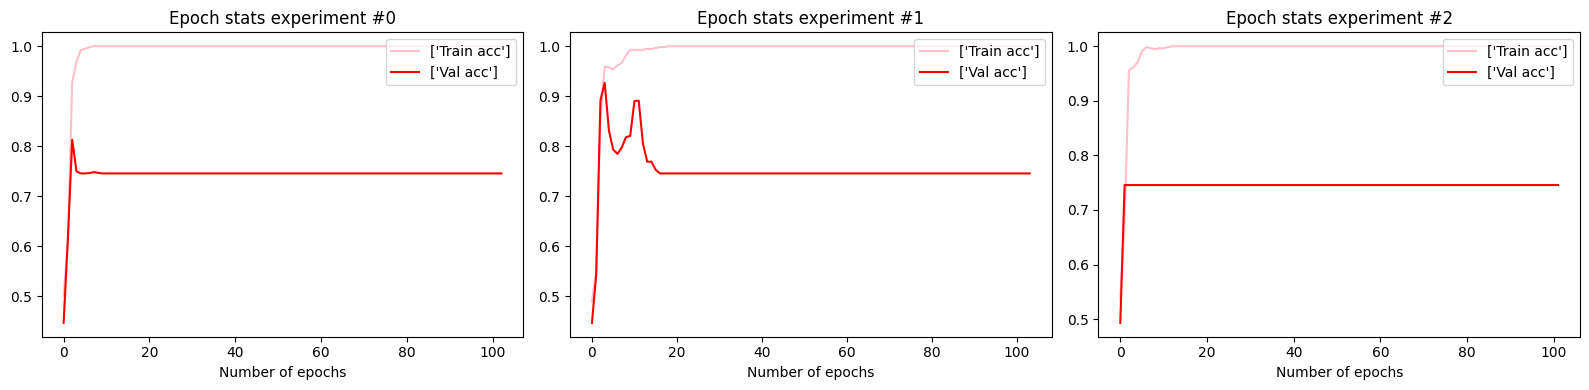

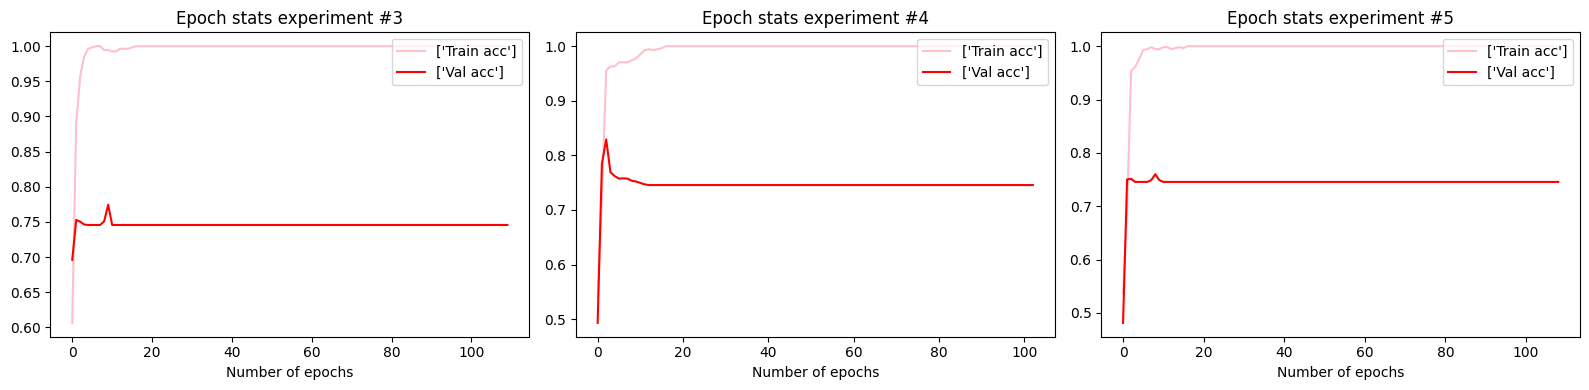

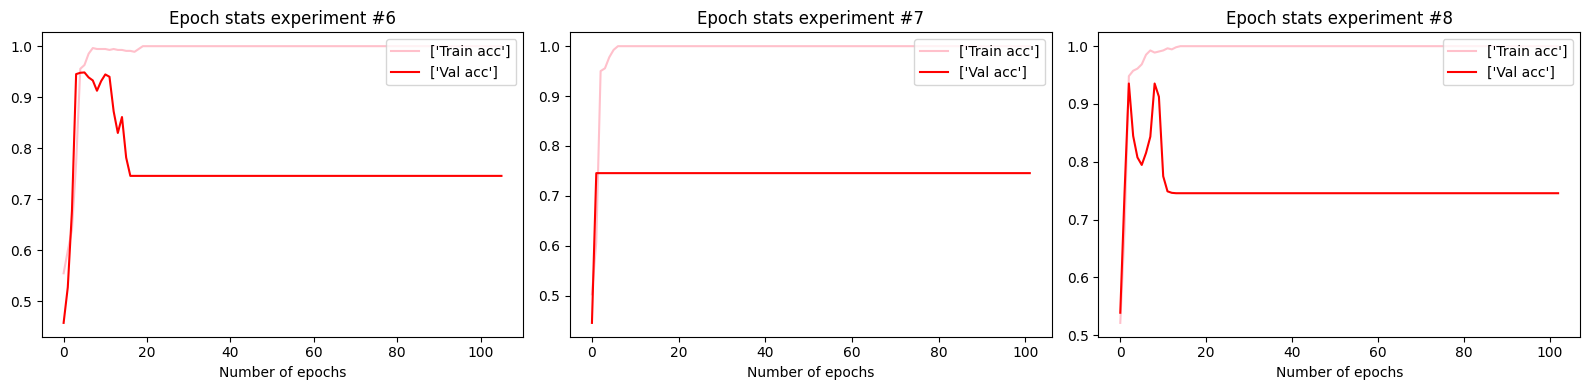

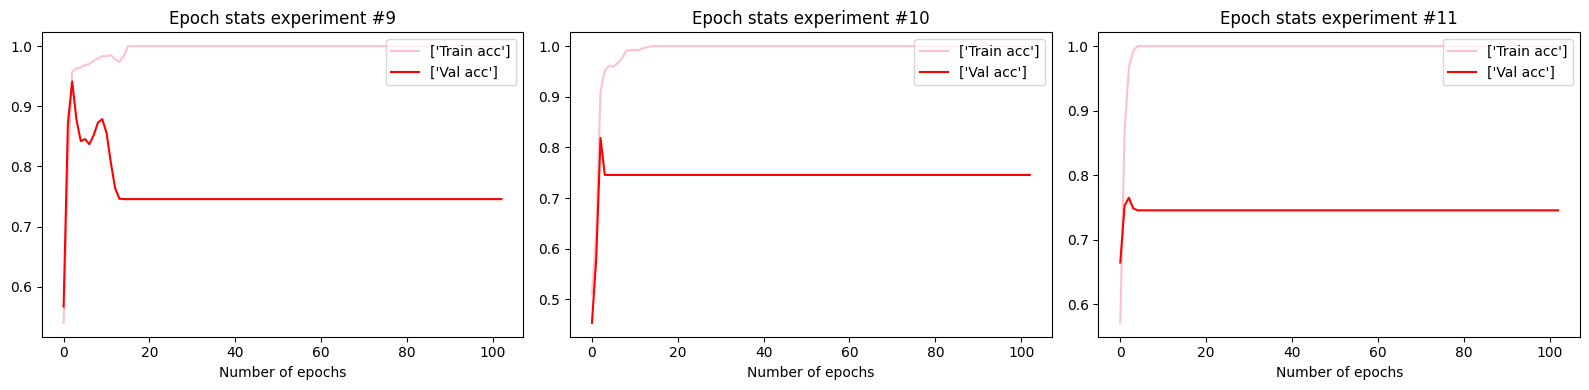

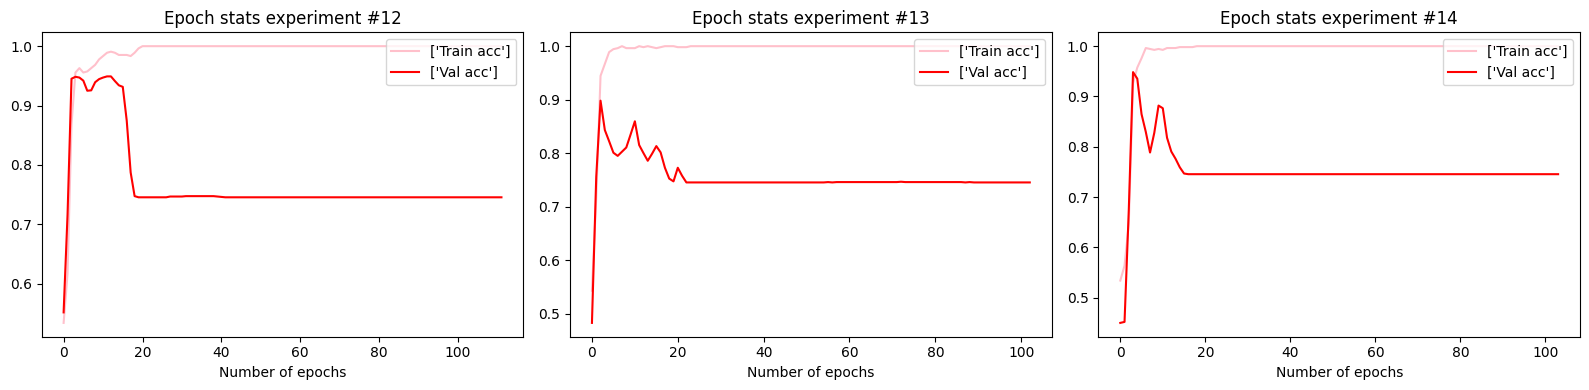

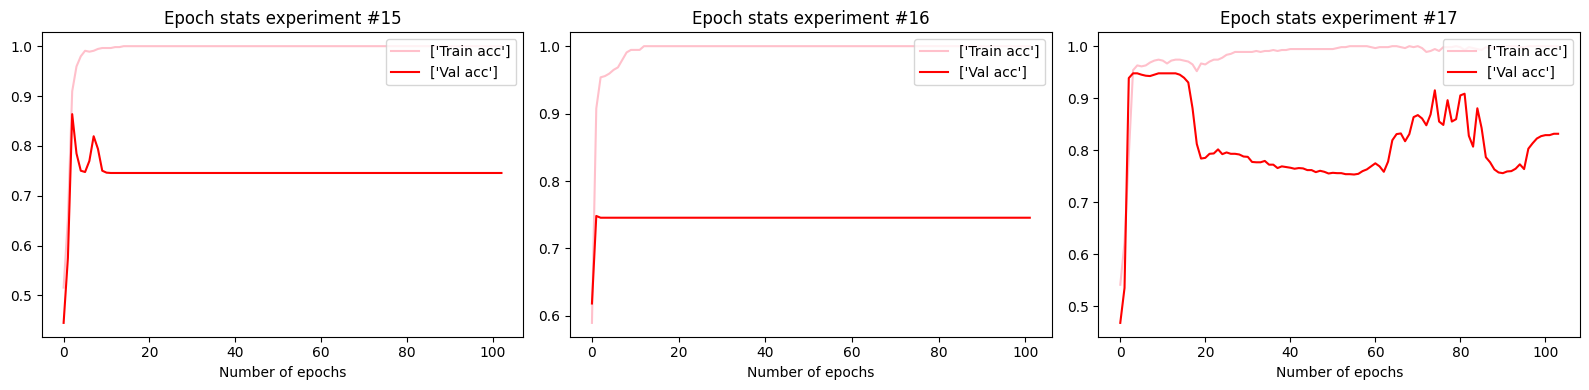

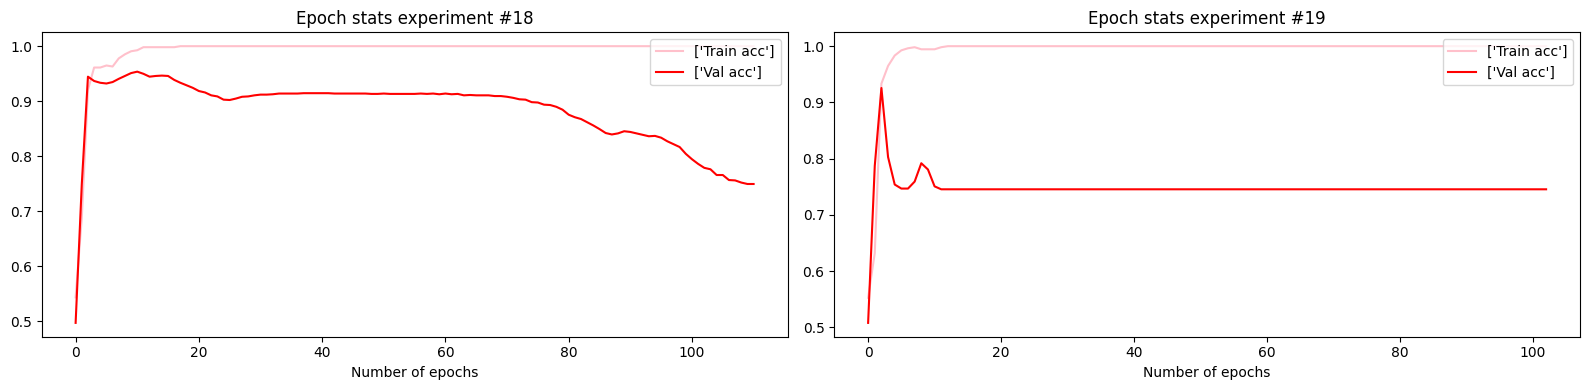

In [ ]:
display_epochs_stats(cnn_epoch_stats, num_experiments, display_train_loss=False, display_val_loss=False)

### LSTM

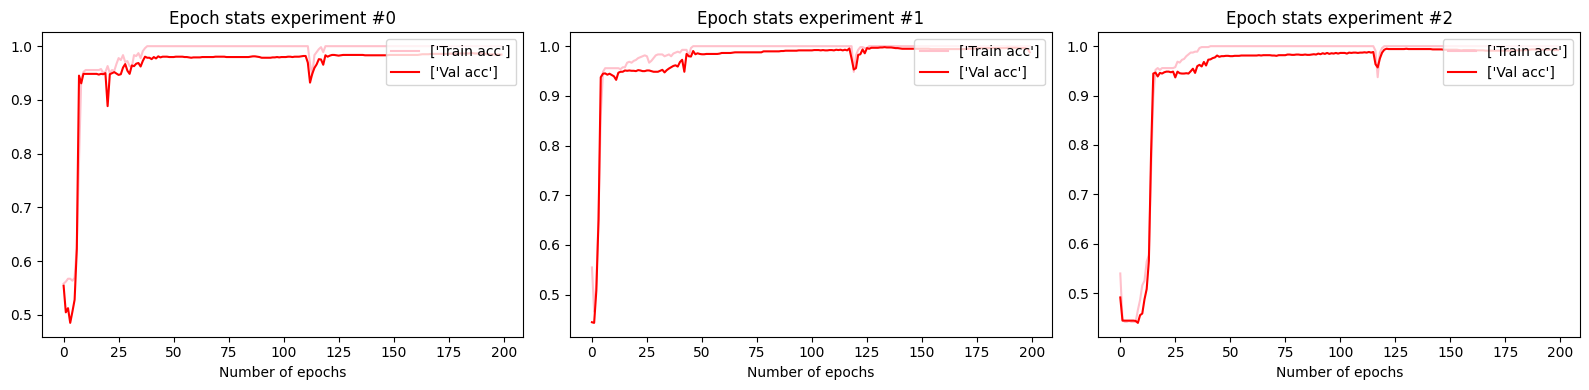

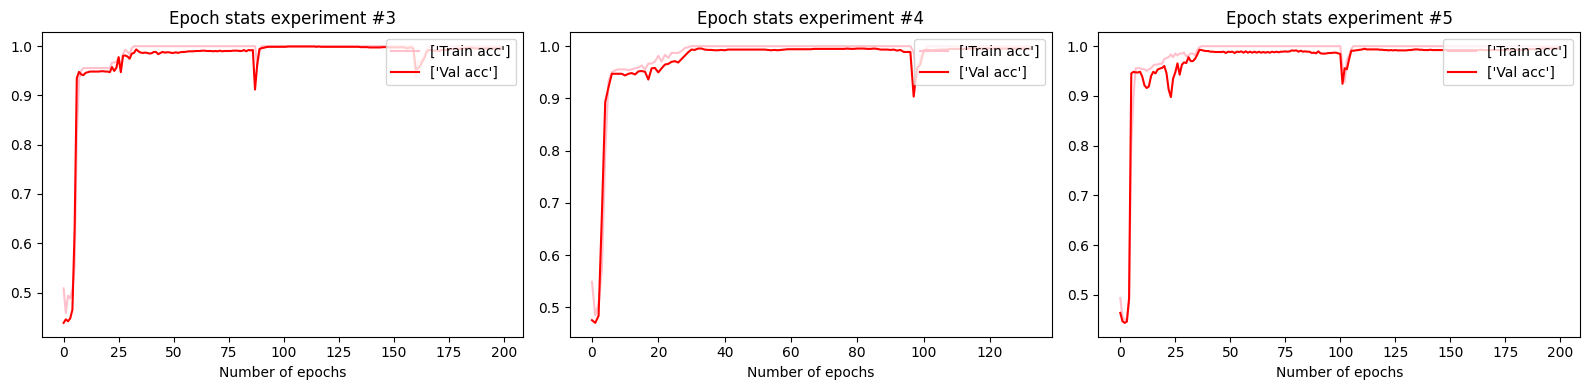

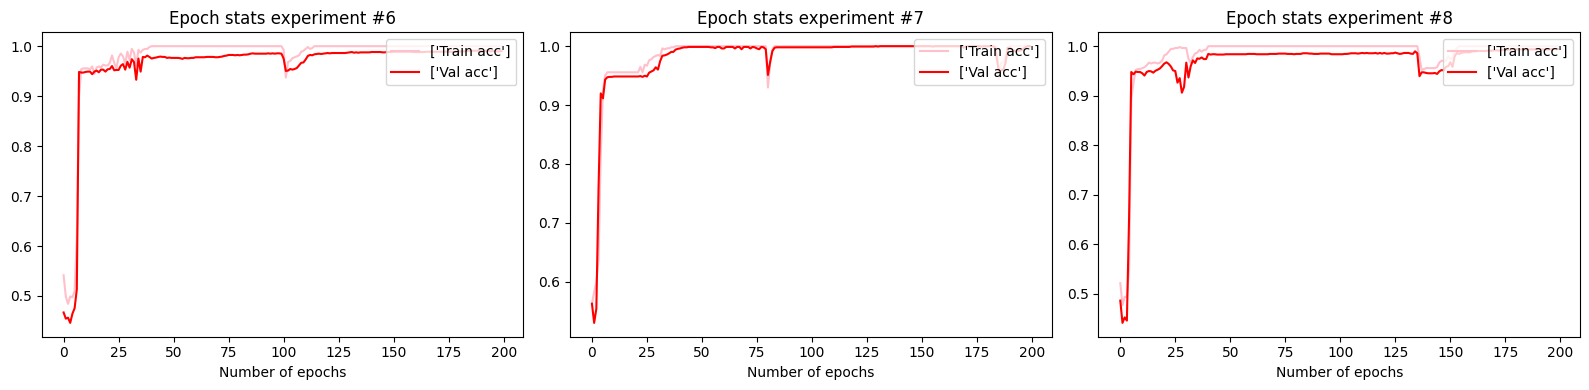

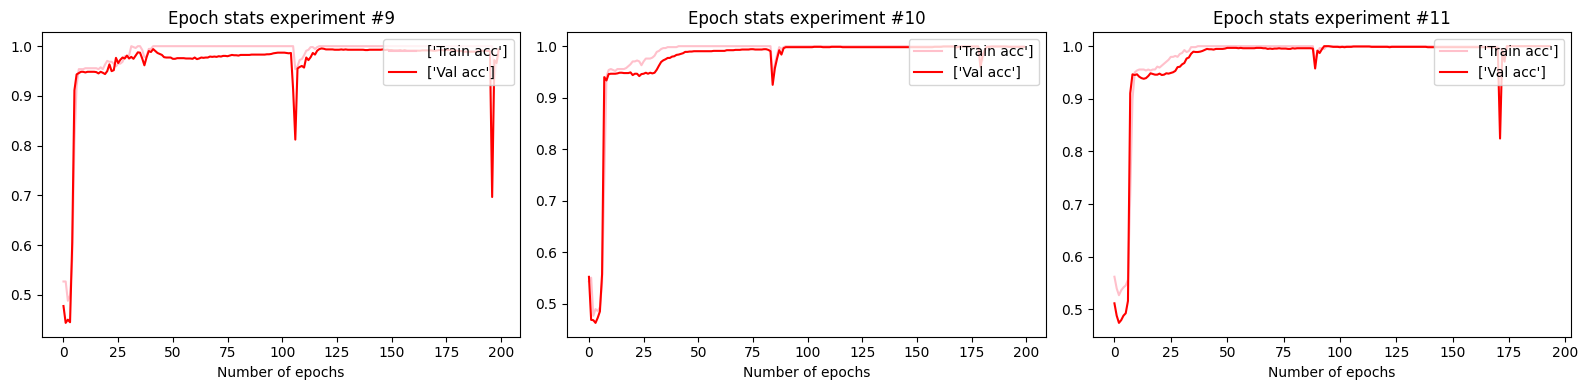

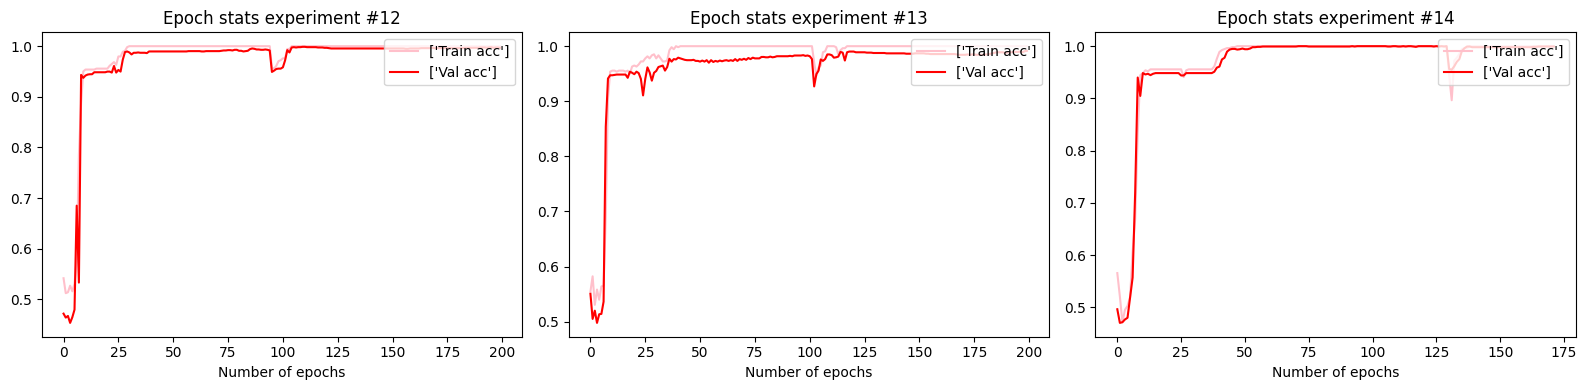

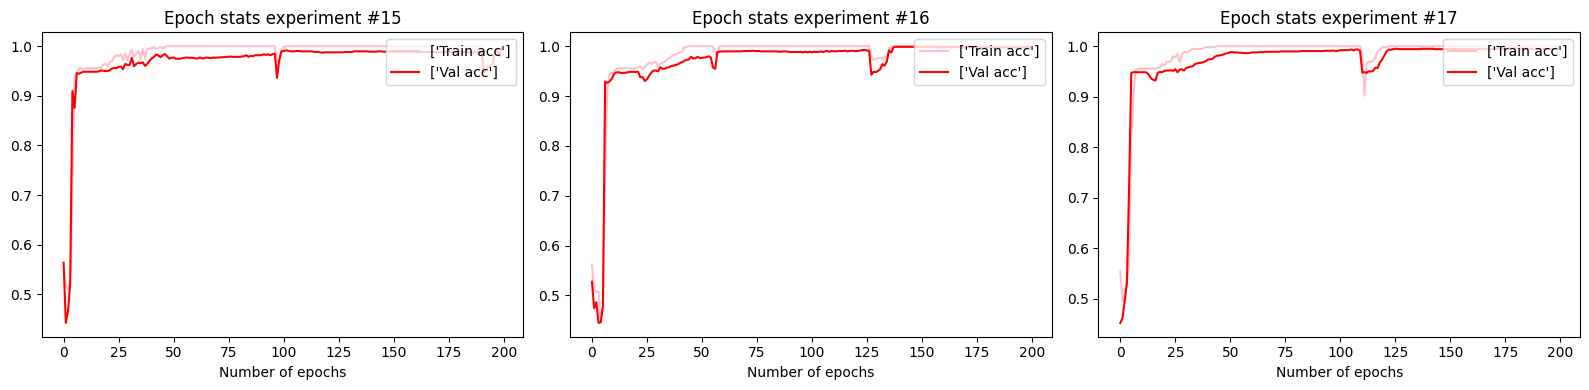

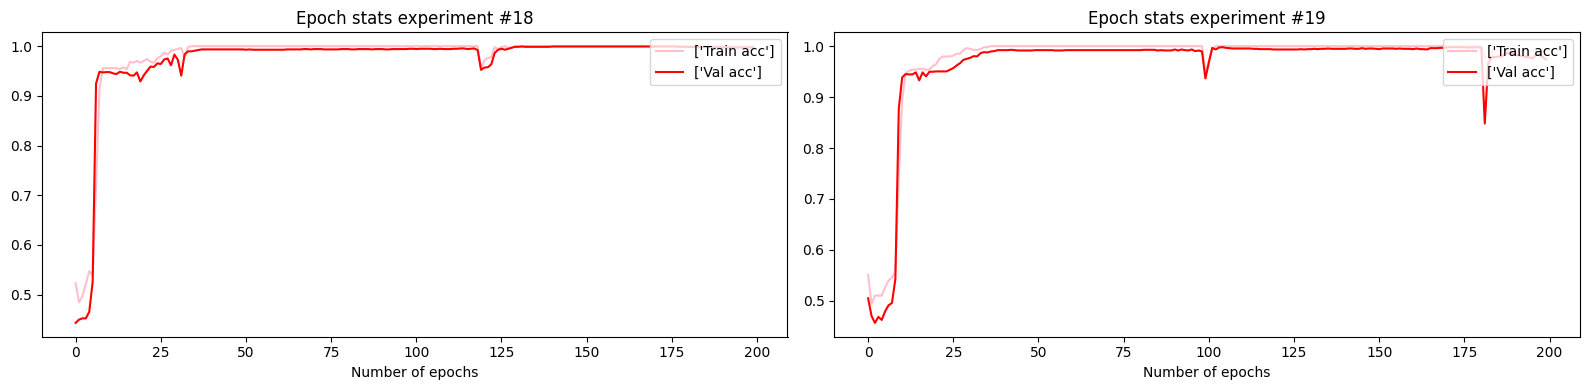

In [ ]:
display_epochs_stats(lstm_epoch_stats, num_experiments, display_train_loss=False, display_val_loss=False)

### DeepSets V1

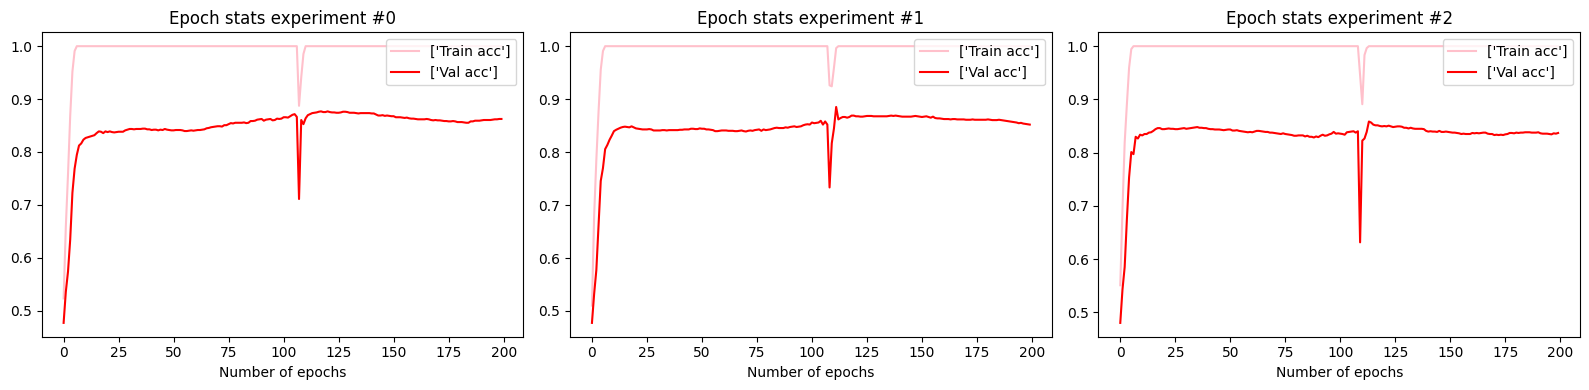

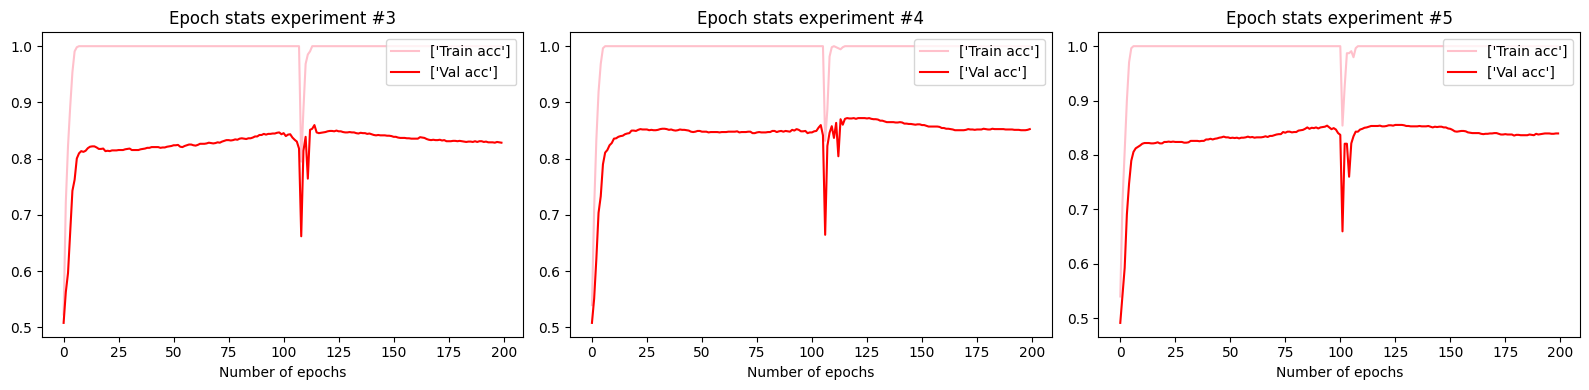

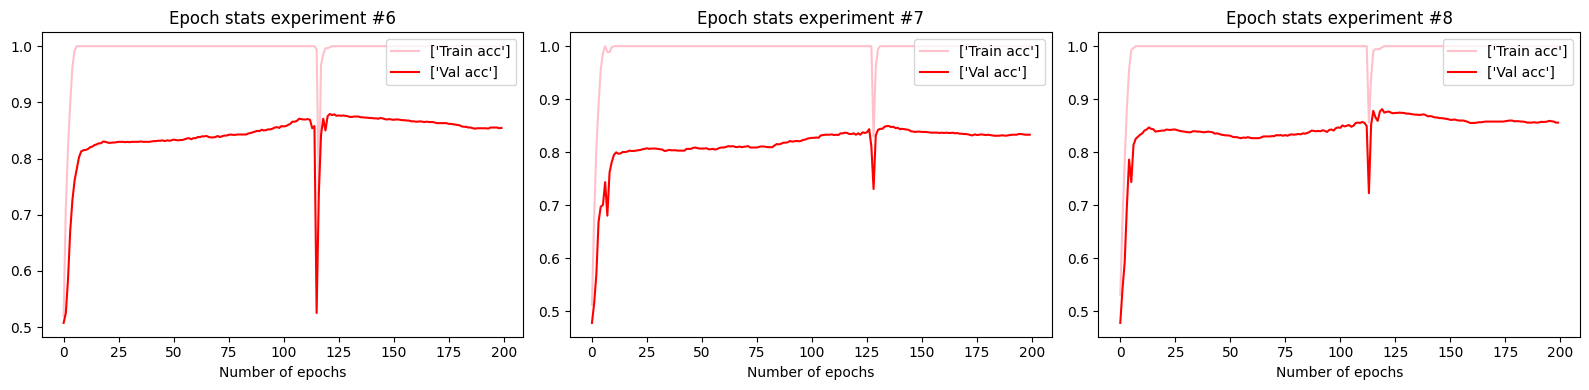

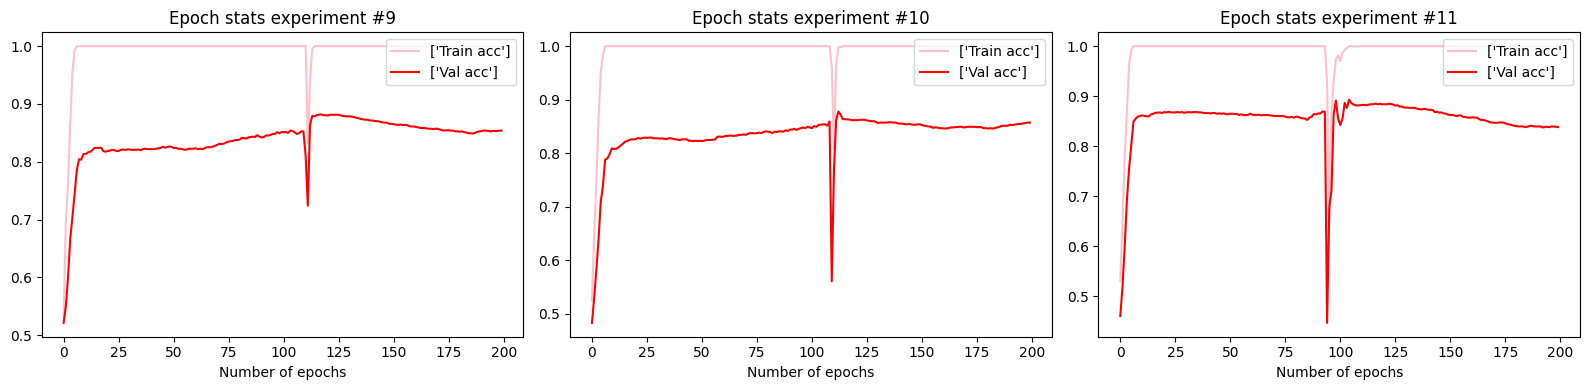

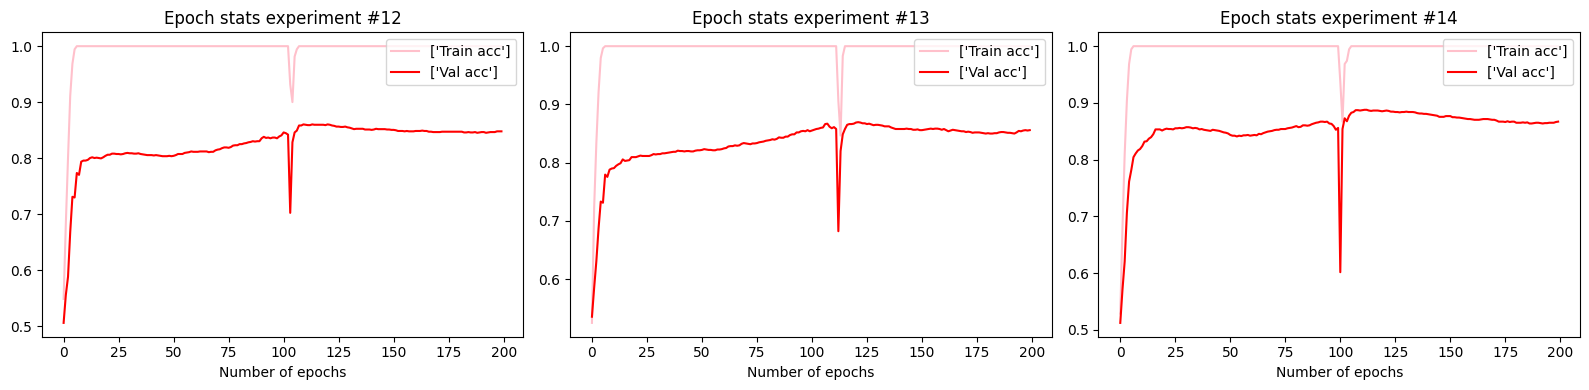

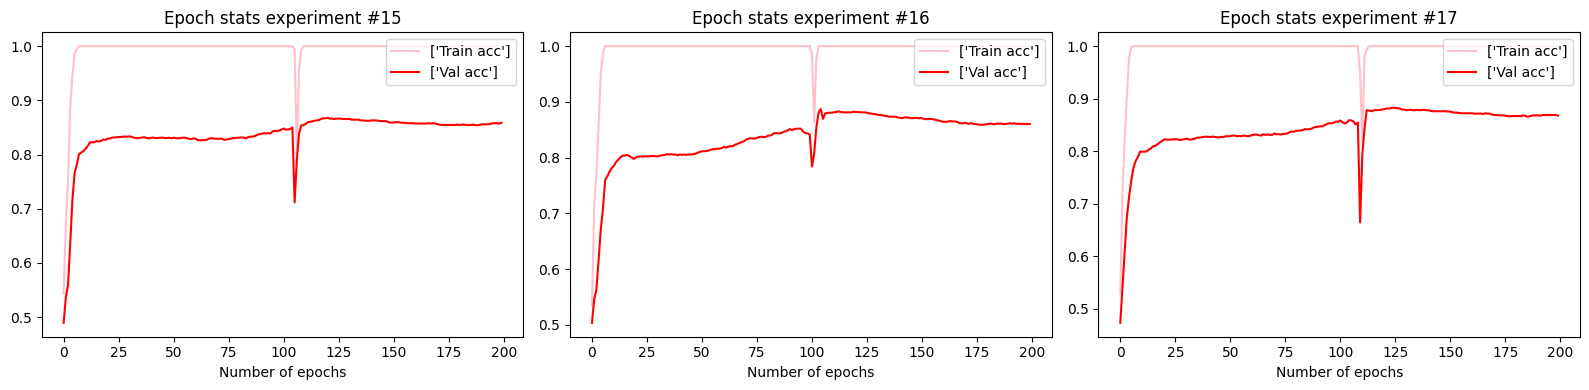

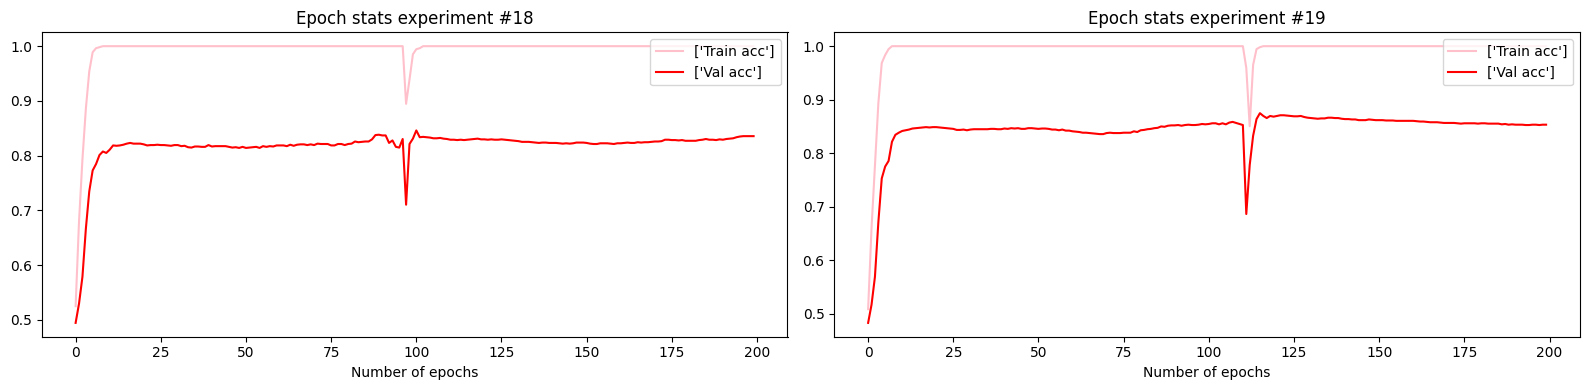

In [ ]:
display_epochs_stats(deepset_epoch_stats, num_experiments, display_train_loss=False, display_val_loss=False)

### DeepSets V2

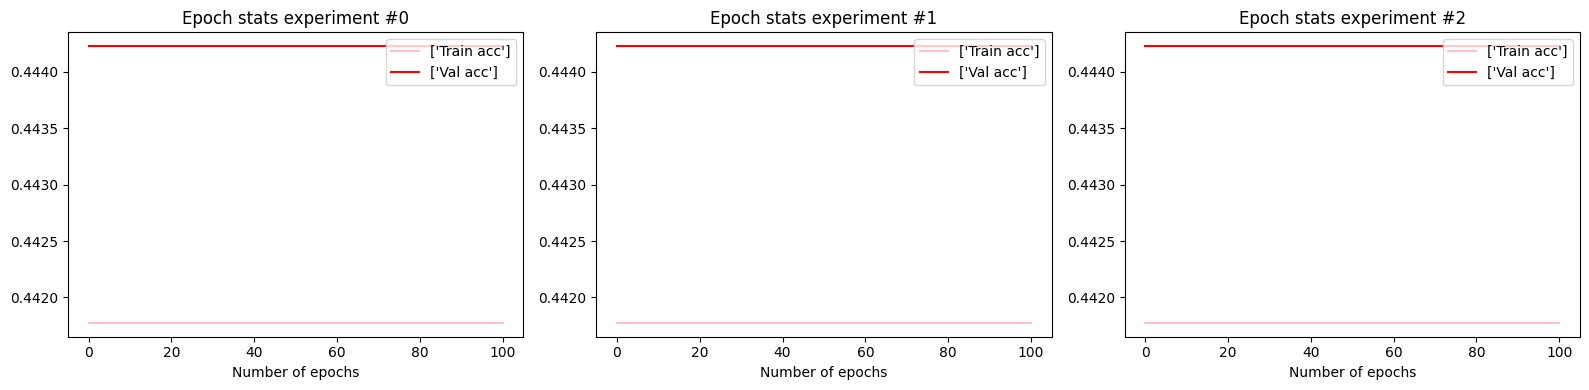

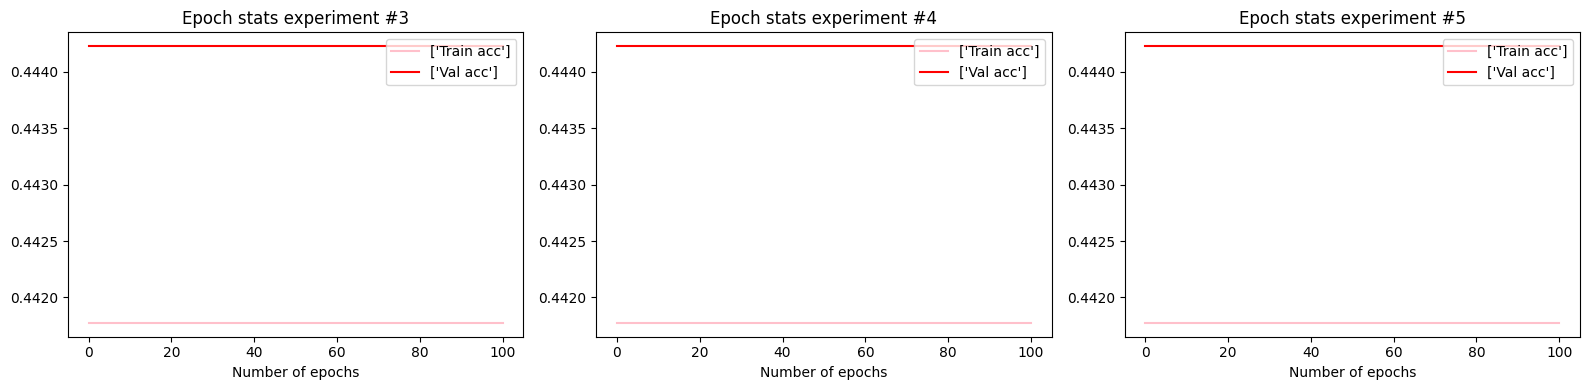

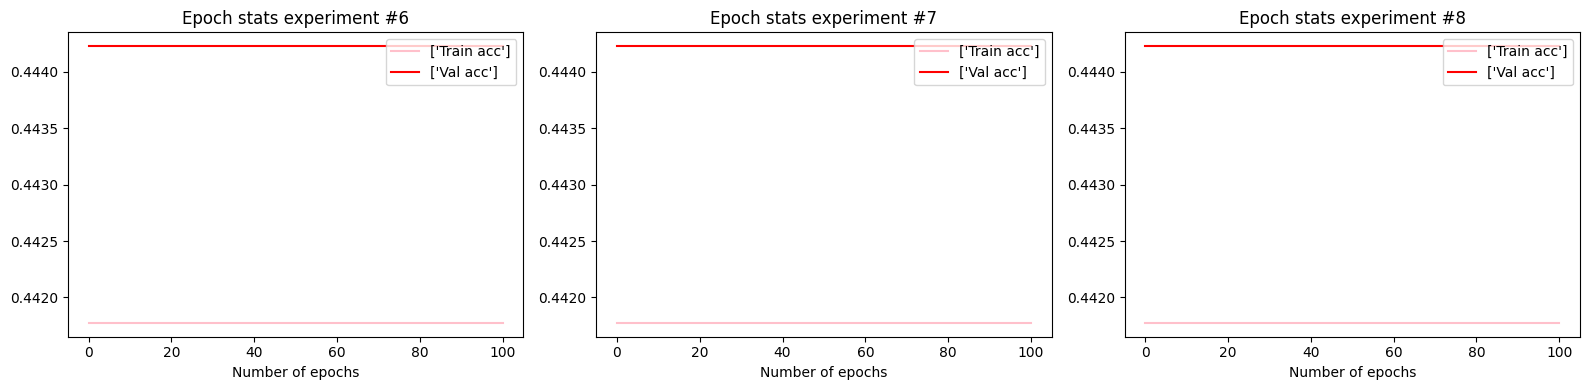

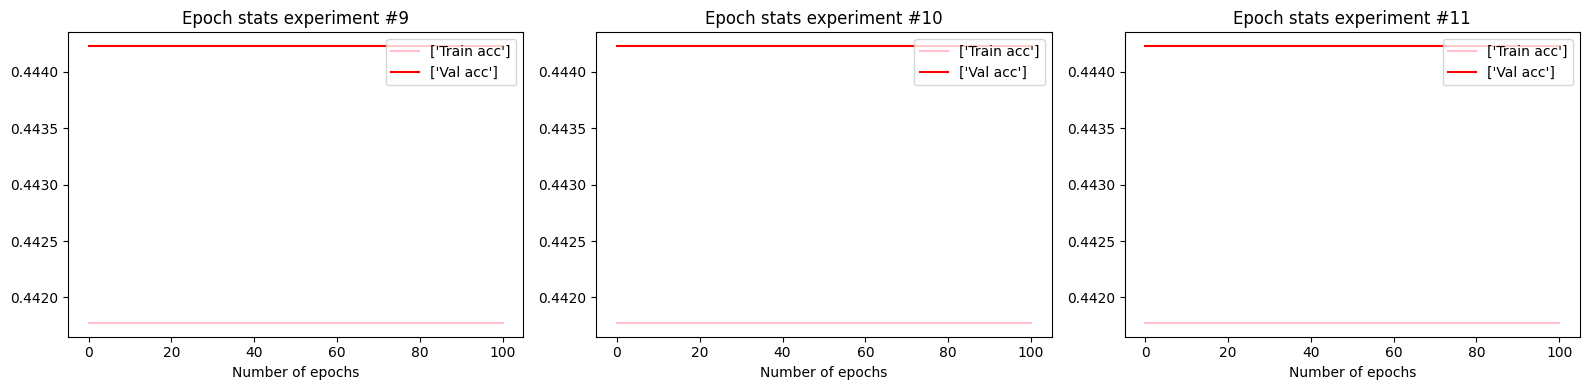

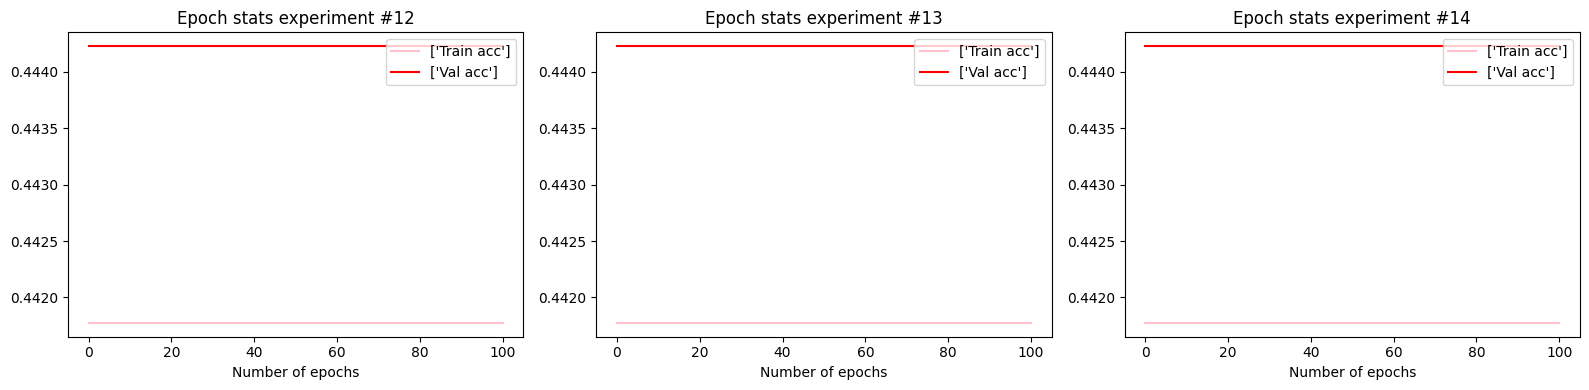

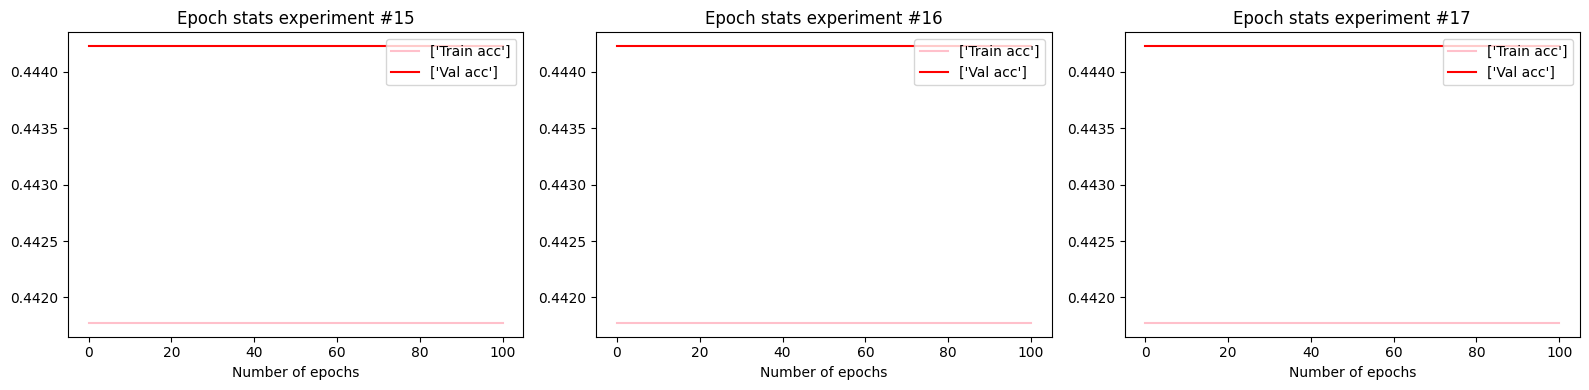

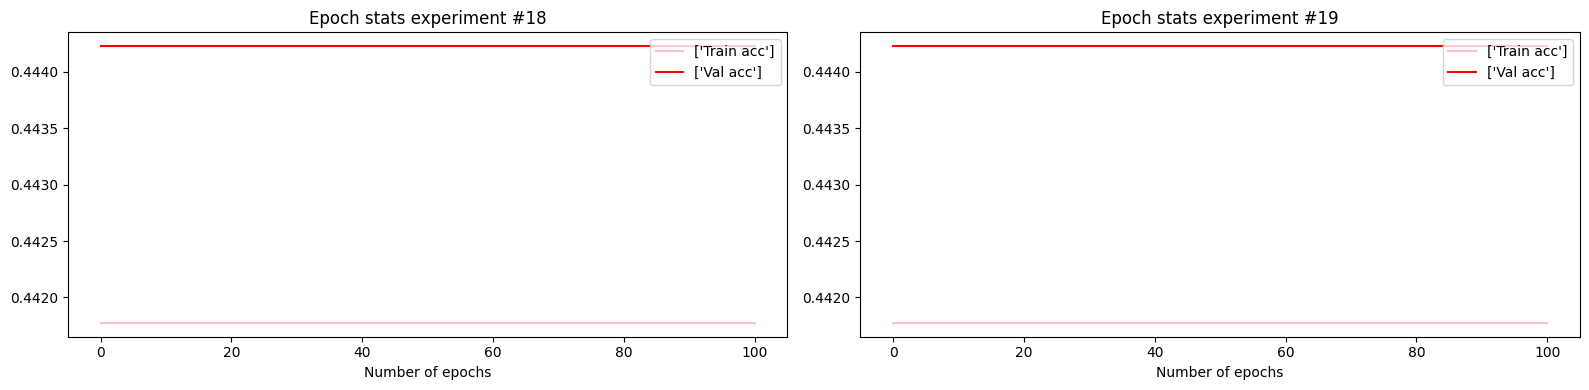

In [ ]:
display_epochs_stats(deepsetv2_epoch_stats, num_experiments, display_train_loss=False, display_val_loss=False)

### FeedForward

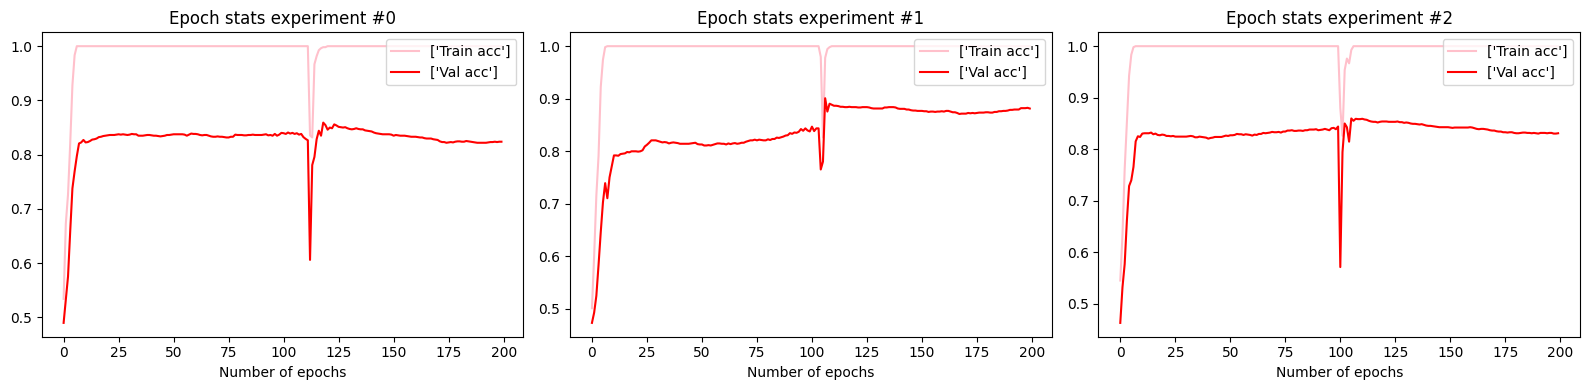

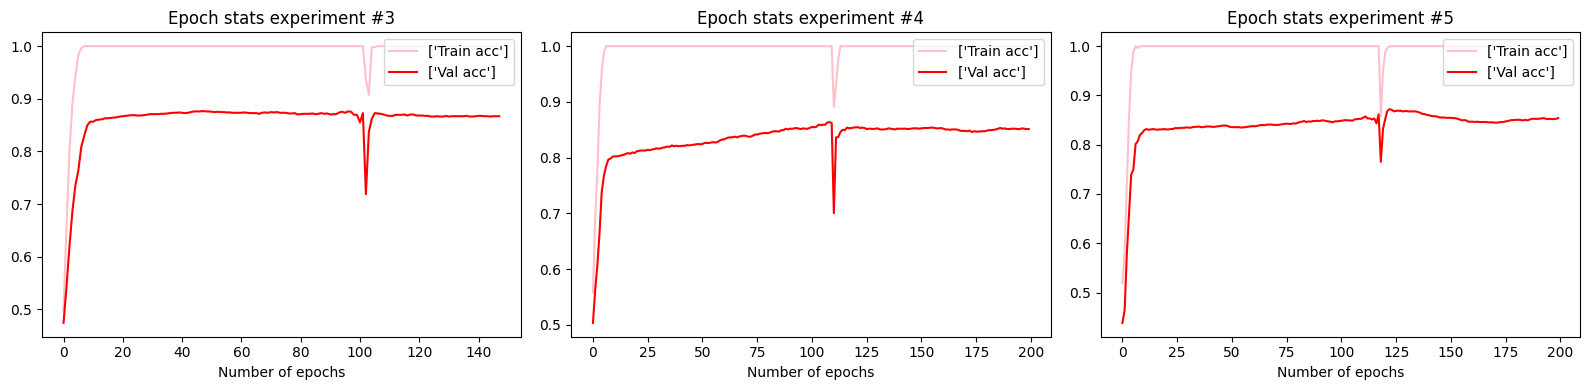

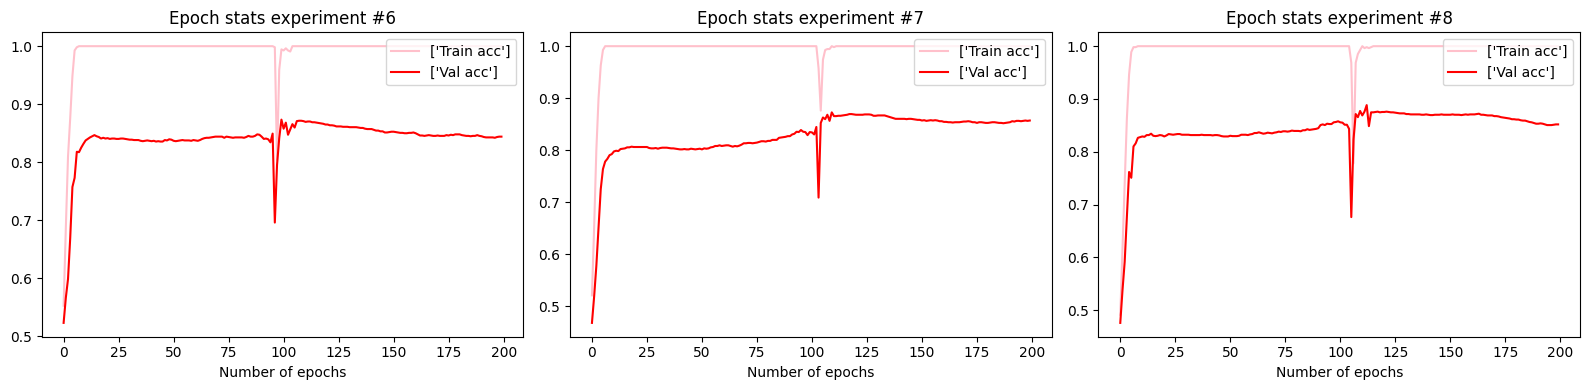

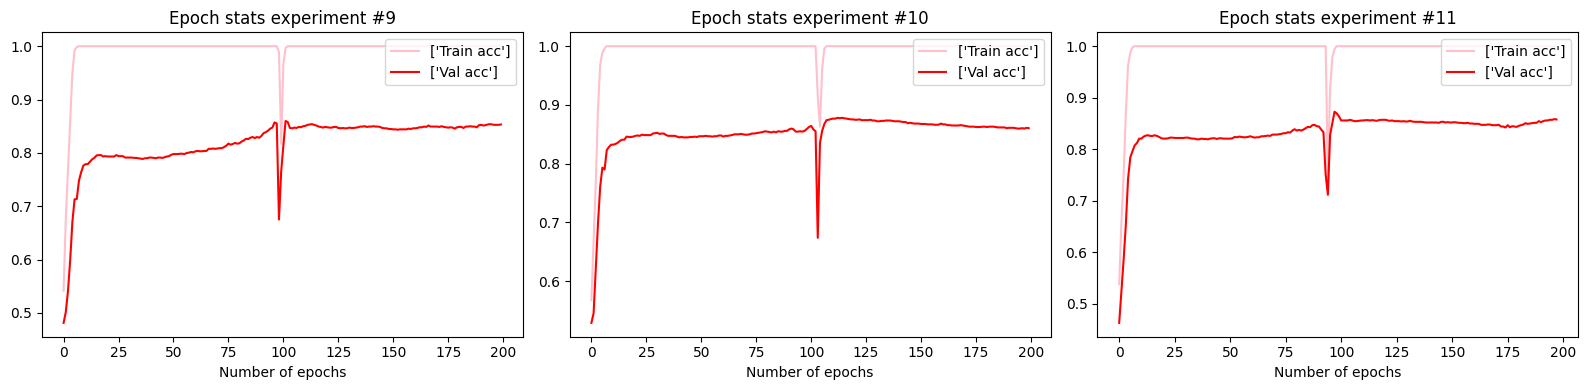

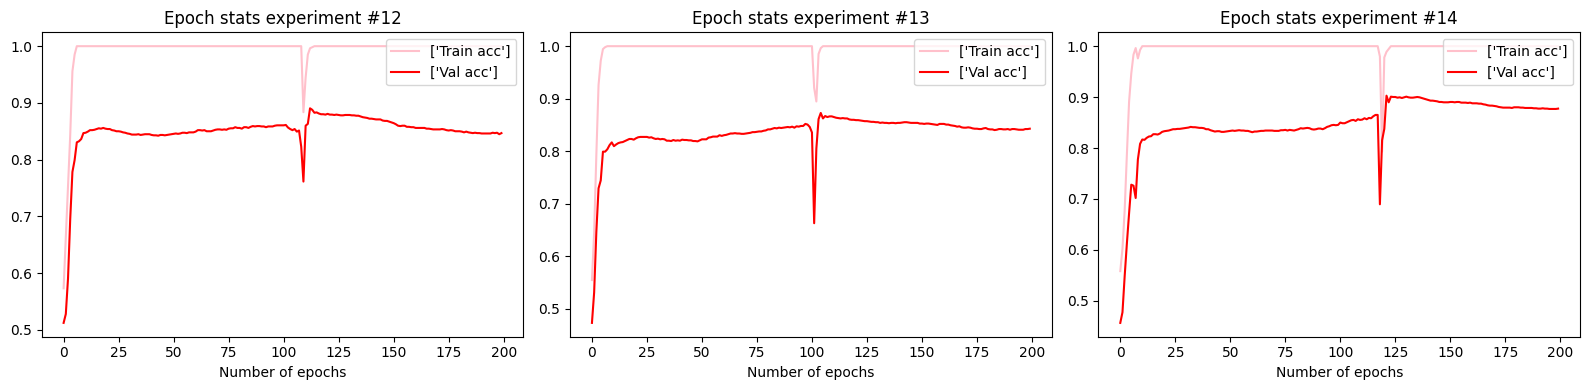

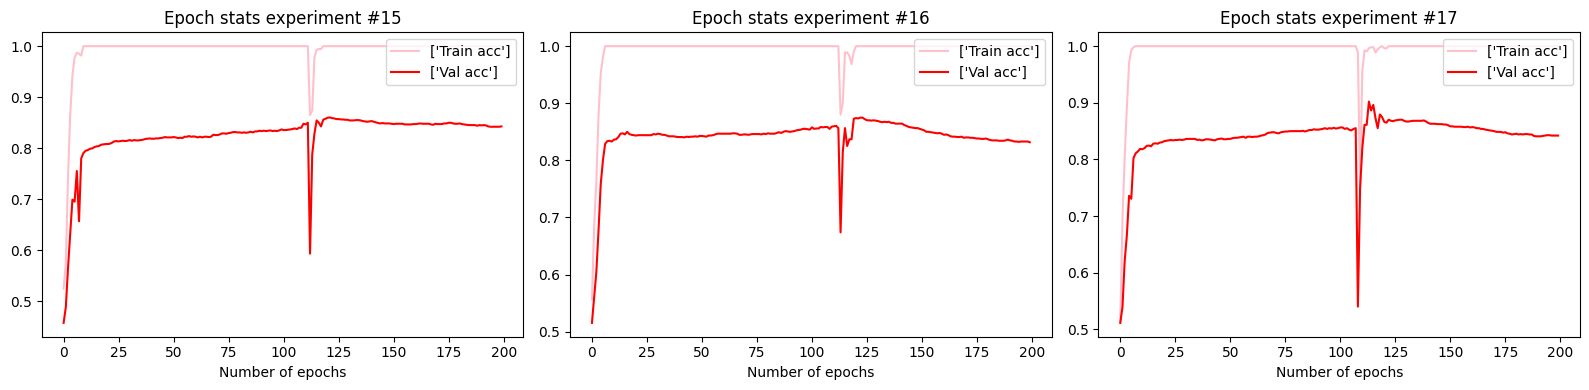

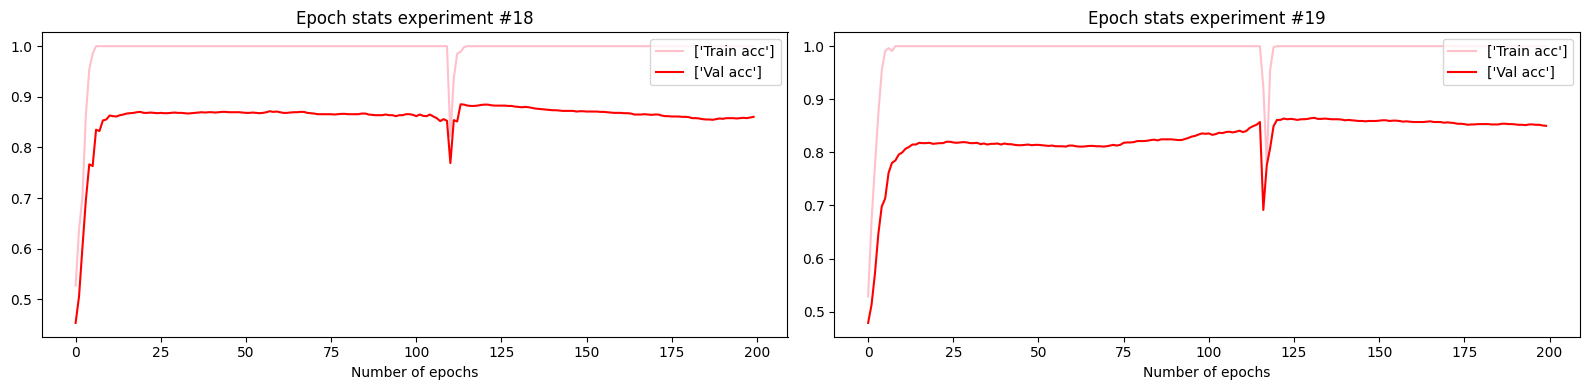

In [ ]:
display_epochs_stats(feedforward_epoch_stats, num_experiments, display_train_loss=False, display_val_loss=False)

# Best performing models

In [ ]:
best_lstm_model = LSTM_Model(data, 16, 32, 8).to(device)
best_lstm_model.load_state_dict(torch.load('./bestmodels/best_LSTM_model'))
best_cnn_model = CNN_Model(data, 32, 64, 4, -1,).to(device)
best_cnn_model.load_state_dict(torch.load('./bestmodels/best_CNN_model'))
best_deepset_model = DEEPSET_Model(data).to(device)
best_deepset_model.load_state_dict(torch.load('./bestmodels/best_DEEPSET_model'))
best_deepsetv2_model = DEEPSETV2_Model(data).to(device)
best_deepsetv2_model.load_state_dict(torch.load('./bestmodels/best_DEEPSETV2_model'))
best_feedforward_model = FEEDFORWARD_Model(data).to(device)
best_feedforward_model.load_state_dict(torch.load('./bestmodels/best_FEEDFORWARD_model'))

<All keys matched successfully>

## Top wrong predictions for best performing CNN model

In [ ]:
print_wrong_preds([get_wrong_predictions(best_cnn_model, x_test_cnn, y_test, test_original)], top_k=10)

Top 10 false positives: 

.,.,__._,.w..u__ _d_,r,.,,,.,._.. | label: False | actual prediction: 0.9822248816490173
.wu...._.._..___ ,___,dr_,_.,_,., | label: False | actual prediction: 0.967210054397583
,.._.,w__u.,_._, .__._d.,r_,_.._, | label: False | actual prediction: 0.964429497718811
,,.,..__,__,.wu, ,,,_,_._.dr_,,_. | label: False | actual prediction: 0.9629058837890625
..w._u,,.,_.._,, ,..__d._r_,.____ | label: False | actual prediction: 0.9621015787124634
_...w_,u_,__,,_, .d._r_,__.______ | label: False | actual prediction: 0.9605904817581177
_....wu.,__.__,_ ,,__,_,dr_,_.,,, | label: False | actual prediction: 0.9597886204719543
_w._u._......,.. _d__r,._.__._,.. | label: False | actual prediction: 0.956299901008606
,,_._.,,,.,wu,,_ ,dr,.,.,.____._, | label: False | actual prediction: 0.9553900957107544
.,,.w..u__.,__,, ..,,_____d__r,,. | label: False | actual prediction: 0.9506938457489014

Top 10 false negatives: 

__u_,w___,._._.. ._,,,__..d,,r._. | label: True | actual pre

## Top wrong predictions for best performing LSTM model

In [ ]:
print_wrong_preds([get_wrong_predictions(best_lstm_model, x_test_lstm, y_test, test_original)], top_k=10)

Top 10 false positives: 

_..,,.,.wu,_____ ,_____..__.__,dr | label: False | actual prediction: 0.8239681720733643

Top 10 false negatives: 

wu,,__,,,.,,..,_ _._._,..,,._,,,r | label: True | actual prediction: 0.20064212381839752
.,_.wu_..__,.... __..._._,.,,_._r | label: True | actual prediction: 0.41025158762931824
_..wu.,,..,_,,_, _,_.,,__,_.,,__r | label: True | actual prediction: 0.43341773748397827
__.,.,wu,,__.__. _,__,,.,._.,_,,r | label: True | actual prediction: 0.4932831823825836
,,.__,,,,.,_wu., ____...___.,.__r | label: True | actual prediction: 0.5378103256225586
,wu_.,,_,,._.,,, .,..,,,_,._,..,r | label: True | actual prediction: 0.599434494972229
__....,._,wu.... ..,,.._,._,.___r | label: True | actual prediction: 0.600082278251648




## Top wrong predictions for best performing DeepSets V1 model

In [ ]:
print_wrong_preds([get_wrong_predictions(best_deepset_model, x_test_normal, y_test, test_original)], top_k=10)

Top 10 false positives: 

_,.,_,..w..u._., ._.,._d,,r_,._., | label: False | actual prediction: 0.9999147653579712
_.____,...,_w,,u ,,,d,.r.,,.,._,. | label: False | actual prediction: 0.9999082088470459
_._,___wu,,.___, .,._._,,,,..dr_. | label: False | actual prediction: 0.9998737573623657
..___.w__u.__,,_ .,.,.,,,.d_.r,_, | label: False | actual prediction: 0.9998674392700195
w_,u._,,_,.,,_., .,,,_,d,.r_.__,_ | label: False | actual prediction: 0.9998668432235718
,__._....wu..__, dr._.__,..._.__, | label: False | actual prediction: 0.9998635053634644
____._,,,.w,_u_, .,.,.,d__r,,.,__ | label: False | actual prediction: 0.9998563528060913
,_,_,,._.w,,u.__ ,,_..,_,._.,d_,r | label: False | actual prediction: 0.9998483657836914
_,___..._,._w_.u ,,._._d..r_..___ | label: False | actual prediction: 0.999846339225769
_,_._,.,,,..,_wu .,dr,.,,.._..___ | label: False | actual prediction: 0.9998254179954529

Top 10 false negatives: 

,__._,.,.___,,,. __..,..,_dr..... | label: True | actual p

## Top wrong predictions for best performing DeepSets V2 model

In [ ]:
print_wrong_preds([get_wrong_predictions(best_deepsetv2_model, x_test_normal, y_test, test_original)], top_k=10)

Top 10 false positives: 


Top 10 false negatives: 

__,_.._,.uw,__,_ ___.,__,__,__dr. | label: True | actual prediction: 0.5
,,,.uw,.,,,.___, ,__dr_,..,,__,,, | label: True | actual prediction: 0.5
.,,,_,,.,.,..,,. _,_.___.._,r._,_ | label: True | actual prediction: 0.5
,__,._._,,,,w,__ .._.,_.,,._dr__. | label: True | actual prediction: 0.5
,_.__.wu_.,,_,_, _..,,r._,_.._.,. | label: True | actual prediction: 0.5
.__.,_,____,_,,. ,.,.___.._...,dr | label: True | actual prediction: 0.5
,,,._,_.,,.,..,. r,,..._,..,..,,_ | label: True | actual prediction: 0.5
_____,_u,.w,_.., _,,.,.,..d__r... | label: True | actual prediction: 0.5
,,_._,___.,,u..w d.,r,.,,,,,...., | label: True | actual prediction: 0.5
.u.,w,.___.__.__ _,d_.r__.,,__,,_ | label: True | actual prediction: 0.5




## Top wrong predictions for best performing Feedforward model

In [ ]:
print_wrong_preds([get_wrong_predictions(best_feedforward_model, x_test_normal, y_test, test_original)], top_k=10)

Top 10 false positives: 

_.._.,,wu,,,__,, .,._,__.,,,._dr. | label: False | actual prediction: 0.9999970197677612
_.____,...,_w,,u ,,,d,.r.,,.,._,. | label: False | actual prediction: 0.9999926090240479
w,.u,..,,_,_..,, _,_d__r.,,_,_,.. | label: False | actual prediction: 0.9999884366989136
.,,,w,,u_.___.__ ,_d__r.._,.._.,. | label: False | actual prediction: 0.9999880790710449
,...,wu,__._..__ ,,_,,.,.,__..dr. | label: False | actual prediction: 0.999977707862854
,.,_.,._..,__.wu _,_._.._.,,,_dr. | label: False | actual prediction: 0.9999771118164062
,..__.,_,,w..u., ,..d_,r.,_,._,,. | label: False | actual prediction: 0.9999749660491943
..,.__,_wu._._,, ,.__._,.,._.dr.. | label: False | actual prediction: 0.9999747276306152
._,_.._..w_,u,,_ .,__,_d..r,.,_., | label: False | actual prediction: 0.9999686479568481
._,,_._,wu_._,,. _,,...,,_,.,,dr, | label: False | actual prediction: 0.9999663829803467

Top 10 false negatives: 

.wu,_,__.,.,_,_, ,..,,.,_..._.r._ | label: True | actual p

# Saving Notebook State

In [ ]:
import dill
dill.dump_session('notebook_env_interop.db')

ModuleNotFoundError: No module named 'dill'

# Loading Notebook State

In [ ]:
import dill
# dill.load_session('notebook_env_interop.db')